In [5]:
import cv2
import requests
import numpy as np
from datetime import datetime, timedelta
import os
import glob

os.chdir('/home/itai/WD-opencv2') #set Working Directory

PATH_to_stream = 'http://192.168.11.115:8080/?action=streaming'
PATH_to_data_directory = '/home/itai/WD-opencv2'+'/data'
dir_path = os.path.dirname(os.path.realpath('__file__'))

Set the Working directory

In [6]:
%pwd
os.getcwd()

'/home/itai/WD-opencv2'

In [7]:
imgs_names_list =list(glob.glob(PATH_to_data_directory  + '/*'))

In [8]:
img = imgs_names_list[0]

In [9]:
img

'/home/itai/WD-opencv2/data/img2021-07-21 14:44:55.073720.jpg'

In [10]:
img = cv2.imread(img)

In [11]:
(h, w, c) = img.shape[:3]
# display the image width, height, and number of channels to our
# terminal
print("width: {} pixels".format(w))
print("height: {}  pixels".format(h))
print("channels: {}".format(c))

width: 1280 pixels
height: 720  pixels
channels: 3


In [12]:
#cv2.imshow("Image", img)
#cv2.waitKey(0)

In [13]:
from IPython.display import display
from PIL import Image
from matplotlib.pyplot import imshow

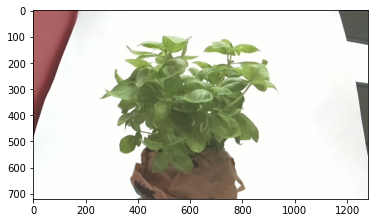

In [14]:
%matplotlib inline
pil_im = Image.open(imgs_names_list[0], 'r')
imshow(np.asarray(pil_im))

In [15]:
image=img.copy()
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([35, 0, 0], dtype="uint8")
upper = np.array([131, 255, 185], dtype="uint8")
mask = cv2.inRange(image, lower, upper)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.fillPoly(mask, cnts, (255,255,255))
result = cv2.bitwise_and(original,original,mask=mask)

cv2.imshow('mask', mask)
cv2.imshow('result', result)
cv2.waitKey()

49

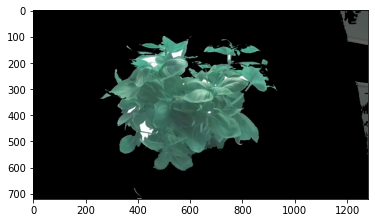

In [16]:
imshow(result)

In [17]:
im = Image.fromarray(result)
im.save("result.jpeg")

In [18]:
im = Image.fromarray(img)
im.save("test_img.jpeg")

Crop

In [19]:
# Cropping an image
cropped_image = img[:,200:1000]
# Display cropped image
cv2.imshow("cropped", cropped_image)
cv2.waitKey()

In [20]:
im = Image.fromarray(cropped_image)
im.save("cropped_image.jpeg")

In [21]:
image=cropped_image.copy()
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([35, 0, 0], dtype="uint8")
upper = np.array([131, 255, 185], dtype="uint8")
mask = cv2.inRange(image, lower, upper)

cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cv2.fillPoly(mask, cnts, (255,255,255))
result = cv2.bitwise_and(original,original,mask=mask)

cv2.imshow('mask', mask)
cv2.imshow('result', result)
cv2.waitKey()

48

In [23]:
im = Image.fromarray(result)
im.save("cropped_result.jpeg")